<a href="https://colab.research.google.com/github/MasahiroAraki/SpeechRecognition/blob/master/Python/chap06a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 例題7.1

scikit-learnを用いてニューラルネットワークの学習を行え

データの準備と表示

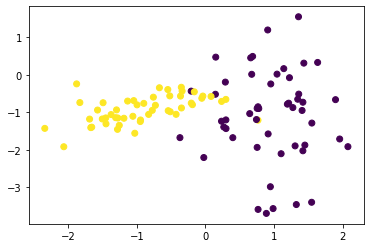

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions

X, y = make_classification(n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=23)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

scikit-learnのMLPClassifierで学習。パラメータはデフォルト。

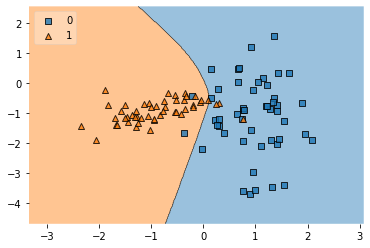

In [2]:
clf = MLPClassifier()
clf.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf, legend=2)

隠れ層のユニット数を4、活性化関数をsigmoidとして学習を行え。学習率や繰り返し回数は適当なものを設定せよ。